In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
from simulate_diffusion import simulate_diffusion
from functools import partial
from collections import OrderedDict
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
tf.enable_eager_execution()

In [4]:
%load_ext autoreload
%autoreload 2

# Model definitions

In [5]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(InvariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform') 
            for _ in range(n_dense)
        ])

        self.post_pooling_dense = tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform')   
        
    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.module(x)
        x = tf.reduce_mean(x, axis=1)
        out = self.post_pooling_dense(x)
        return out
    

class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(EquivariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu') 
            for _ in range(n_dense)
        ])
        
        self.invariant_module = InvariantModule(h_dim, n_dense)
        
    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out
    

class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a 
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, h_dim, n_dense=3, n_equiv=2):
        """
        Creates a permutationally invariant network 
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        n_equiv : int -- the number of equivariant modules 
        """
        
        super(InvariantNetwork, self).__init__()
        
        self.equiv = tf.keras.Sequential([
            EquivariantModule(h_dim, n_dense)
            for _ in range(n_equiv)
        ])
        self.inv = InvariantModule(h_dim, n_dense)
        
    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant 
        representation by first passing it through multiple equivariant 
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out
    
    
class SelfAttentionHead(tf.keras.Model):
    """Implements a single self-attention head."""

    def __init__(self, key_dim=64, dense_dim=128):
        super(SelfAttentionHead, self).__init__()
        
        self.Wq = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wk = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.Wv = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        
        self.dense_part = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, kernel_initializer='glorot_uniform')
        ])
        
        
        self.scale = np.sqrt(key_dim)
              
    def call(self, x):
        """
        Passes the input through an attention head and then through a shared dense layer.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, n, h_dim) -- the trasnformed representation of the input
        """

        # Obtain queries, keys, and values
        queries = self.Wq(x)
        keys = self.Wk(x)
        values = self.Wv(x)
        
        # Compute self-attention matrices
        qk_t = tf.einsum('bij,bkj->bik', queries, keys)
        weights = tf.nn.softmax(qk_t / self.scale, axis=-1)
        z = tf.einsum('bik,bkj->bij', weights, values)
        
        # Pass through final dense
        out = self.dense_part(z)
        return out


class AttentionNetwork(tf.keras.Model):
    """
    Implements a network with multi-head self-attention architecture after Vaswani et al. (2017).
    """

    def __init__(self, n_heads=8, key_dim=64):
        """
        Creates aan attention network composed of multiplke heads and a pooling layer
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        n_heads   : int -- the number of attention heads
        key_dim   : int -- the dimensionality of the attention keys
        """
        super(AttentionNetwork, self).__init__()
        
        self.Wo = tf.keras.layers.Dense(key_dim, use_bias=False, kernel_initializer='glorot_uniform')
        self.attention_heads = [SelfAttentionHead(key_dim) for _ in range(n_heads)]
        
        
    def call(self, x, **args):
        """
        Passes the input through multiple attention head, pools the output of the multiple heads 
        and then passed the pooled output through a dense layer.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : the trasnformed input after attention, pooling and non-linearity
        """

        # Calculate attention
        x = tf.concat([head(x) for head in self.attention_heads], axis=-1)
        o = self.Wo(x)
        return o

In [6]:
class DesignIndependentNetwork(tf.keras.Model):
    def __init__(self, n_params=7, invariant_dim=128, attention_dim=128, 
                 dense_dim=128, n_heads=4, n_attention=1):
        super(DesignIndependentNetwork, self).__init__()
        
        self.inv1 = InvariantNetwork(invariant_dim, n_equiv=3)
        
        self.attention_stack = tf.keras.Sequential([
            AttentionNetwork(n_heads, attention_dim)
            for _ in range(n_attention)
        ])
        
        self.distributed_dense = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(n_params*2, kernel_initializer='glorot_uniform'),
        ])
        
        self.inv2 = InvariantNetwork(invariant_dim)
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(dense_dim, activation='elu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.Dense(n_params*2, kernel_initializer='glorot_uniform'),
        ])
        
        
    def call(self, x):
        
        # Compute varying parameters 
        x = tf.split(x, x.shape[2], axis=-1)
        x = tf.stack([self.inv1(x_c) for x_c in x], axis=1)
        x = self.distributed_dense(x)
        mean_d, var_d = tf.split(x, 2, axis=-1)
        var_d = tf.nn.softplus(var_d)
        
        # Compute shared parameters
        x = self.attention_stack(x)
        x = self.inv2(x)
        x = self.dense(x)
        mean_s, var_s = tf.split(x, 2, axis=-1)
        var_s = tf.nn.softplus(var_s)

        return mean_d, var_d, mean_s, var_s
    
    def estimate_parameters(self, x, mask_var, mask_shared):
        
        mean_d, var_d, mean_s, var_s = self.call(x)
        c = int(x.shape[2])
        
        means = tf.concat([tf.gather(mean_d[:, i, :], mask_var, axis=-1) for i in range(c)] + 
                          [tf.gather(mean_s, mask_shared, axis=-1)], axis=-1)
        vars = tf.concat([tf.gather(var_d[:, i, :], mask_var, axis=-1) for i in range(c)] + 
                          [tf.gather(var_s, mask_shared, axis=-1)], axis=-1)
        return means, vars

# Utility functions

In [7]:
def heteroscedastic_loss(y_true, y_mean, y_var):
    """
    Computes the heteroscedastic loss for regression.

    ----------
    Arguments:
    y_true : tf.Tensor of shape (batch_size, n_out_dim) -- the vector of true values
    y_mean : tf.Tensor of shape (batch_size, n_out_dim) -- the vector fo estimated conditional means
    y_var  : tf.Tensor of shape (batch_size, n_out_dim) -- the vector of estimated conditional variance
             (alleatoric uncertainty)
    ----------
    Returns:
    loss : tf.Tensor of shape (,) -- a single scalar value representing thr heteroscedastic loss

    """

    logvar = tf.reduce_sum(0.5 * tf.log(y_var), axis=-1)
    squared_error = tf.reduce_sum(0.5 * tf.square(y_true - y_mean) / y_var, axis=-1)
    loss = tf.reduce_mean(squared_error + logvar)
    return loss

In [8]:
def index_parameters(X_batch, theta_batch, mask_shared, mask_var):
    
    c = int(theta_batch.shape[2])
    theta_batch = tf.concat(
            [tf.gather(theta_batch[:, :, i], mask_var, axis=-1) for i in range(c)] + 
            [tf.gather(theta_batch[:, :, 0], mask_shared, axis=-1)], axis=1)
    return X_batch, theta_batch

In [9]:
def plot_true_est_scatter(model, y_pred, y_test, params_names, figsize=(20, 4), filename=None):
    """Plots a scatter plot with abline of the estimated posterior means vs true values."""
    
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()
    
    # Initialize figure

    # Determine figure layout
    if len(param_names) >= 6:
        n_col = int(np.ceil(len(param_names) / 2))
        n_row = 2
    else:
        n_col = int(len(param_names))
        n_row = 1

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row > 1:
        axarr = axarr.flat

    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(params_names)):
        
        # Plot true vs estimated
        axarr[j].scatter(y_test[:, j], y_pred[:, j], color='black', alpha=0.4)
        
        # Plot AB line
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSD
        rmse = np.sqrt(np.mean( (y_pred[:, j] - y_test[:, j])**2 ))
        nrmse = rmse / (y_pred[:, j].max() - y_test[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        # Compute R2
        r2 = r2_score(y_pred[:, j], y_test[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=10)
        
        if j == 0:
            # Label plot
            axarr[j].set_xlabel('True')
            axarr[j].set_ylabel('Estimated')
        axarr[j].set_title(params_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
    
    # Adjust spaces
    f.tight_layout()
    
    if filename is not None:
        f.savefig('figures/Splatter_scatter.png', dpi=600)
    
    plt.show()

In [10]:
def train_online_heteroscedastic(model, optimizer, data_generator, iterations, batch_size,
                                 X_test, theta_test, p_bar, mask_var, mask_shared, global_step=None, 
                                 transform=None, clip_value=5.):
    """
    Utility function to perform the # number of training loops given by the itertations argument.
    """
    
    for it in range(iterations):

        X_batch, theta_batch = data_generator(batch_size)
        
        if transform is not None:
                X_batch, theta_batch = transform(X_batch, theta_batch)

        with tf.GradientTape() as tape:
            
            # Forward pass
            theta_mean, theta_var = model.estimate_parameters(X_batch, mask_var, mask_shared)
            
            # Compute total loss
            loss = heteroscedastic_loss(theta_batch, theta_mean, theta_var)

        # One step backprop
        gradients = tape.gradient(loss, model.trainable_variables)

        # Validation and training scores
        theta_mean_val, theta_var_val = model.estimate_parameters(X_test, mask_var, mask_shared)
        train_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(theta_batch - theta_mean), axis=-1), axis=-1))  
        val_rec = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(theta_test - theta_mean_val), axis=-1), axis=-1))
        val_loss = heteroscedastic_loss(theta_test, theta_mean_val, theta_var_val)


        if clip_value is not None:
            gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)

        # Update p-bar
        p_bar.set_postfix_str("It: {0},Loss:{1:.3f},Val.Loss:{2:.3f},Rec.:{3:.3f},Val.Rec.:{4:.3f}".format(
        it, loss.numpy(), val_loss.numpy(), train_rec.numpy() , val_rec.numpy()))
        p_bar.update(1)

# Simulation and training settings

In [11]:
# --- Training hyperparameters --- #
param_names = [r'$v_{1}$', r'$a_{1}$', r'$v_{2}$', r'$a_{2}$', r'$sv$', r'$zr$',
               r'$t_{0}$']
theta_dim = len(param_names)
batch_size = 64
summary_dim = 128
epochs = 50
iterations_per_epoch = 1000
n_test = 300
n_samples_posterior = 2000
learning_rate = 0.001
n_trials = 200
clip_value = 5.
global_step = tfe.Variable(0, dtype=tf.int32)

In [12]:
parameter_settings = OrderedDict([
        ('v', [(-6, 6), (-6, 6)]),
        ('sv', [(0.0, 1.0)]),
        ('zr', [(0.3, 0.75)]),
        ('szr', 0),
        ('a', [(0.2, 3.5), (0.2, 3.5)]),
        ('ndt', [(0.3, 1.5)]),
        ('sndt', 0),
        ('alpha', 2.0)
    ])

In [13]:
%%time
X_test, theta_test, fi, vi, si = simulate_diffusion(n_test, parameter_settings, 
                                                    n_points=500, return_indices=True)

Wall time: 2.83 s


In [14]:
data_gen = partial(simulate_diffusion, p_settings=parameter_settings, n_trials_min=60, n_trials_max=500)
transform = partial(index_parameters, mask_shared=si, mask_var=vi)

In [15]:
X_test, theta_test = transform(X_test, theta_test)

In [16]:
model = DesignIndependentNetwork()
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Plot untrained

Instructions for updating:
Colocations handled automatically by placer.


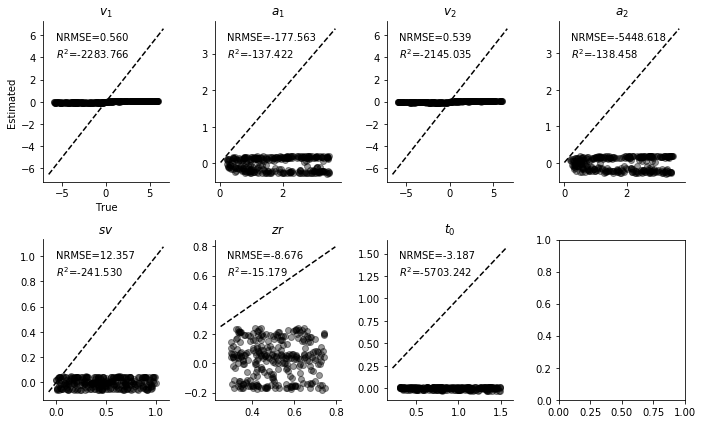

In [17]:
theta_pred = model.estimate_parameters(X_test, vi, si)[0]
plot_true_est_scatter(model, theta_pred, theta_test, 
                      param_names, figsize=(10, 6), filename=None)

In [18]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [23]:
# for ep in range(1, epochs+1):
#     with tqdm(total = iterations_per_epoch, desc='Epoch {}'.format(ep)) as p_bar:
        
#         # Run epoch
#         train_online_heteroscedastic(model, optimizer, data_gen, iterations_per_epoch, batch_size,
#                                      X_test, theta_test, p_bar, vi, si, transform=transform, 
#                                      clip_value=clip_value, global_step=global_step)
        
#         # Predict test
#         theta_pred = model.estimate_parameters(X_test, vi, si)[0]
#         plot_true_est_scatter(model, theta_pred, theta_test, 
#                       param_names, figsize=(10, 6), filename=None)
        
#         manager.save()

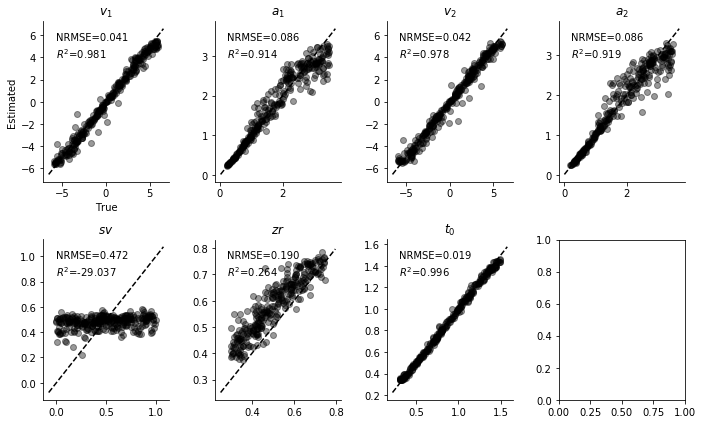

In [22]:
# Predict test
theta_pred = model.estimate_parameters(X_test, vi, si)[0]
plot_true_est_scatter(model, theta_pred, theta_test, 
              param_names, figsize=(10, 6), filename=None)